# Introduction

## The project

Our project focuses on the Minihack environment called HideNSeek. This environment consists of a labyrinth with trees and clouds. The agent's goal is to reach the stairs without being killed by the monster. There are different versions of this environment, but our project primarily concentrates on the Mapped version, where the environment is fully observable, and the standard version of HideNSeek, where the environment is partially observable and revealed to the agent as it explores the map. Our project is structured around two distinct approaches: a knowledge base and the A* pathfinding algorithm. Initially, both techniques were explored in parallel. For both, we started with a simplified version of the problem, beginning with a fully observable environment. Initially, the map only contained trees, and later clouds and monsters were included.

Subsequently, we integrated the two strategies in different ways, which will be detailed later. Finally, we transitioned to the partially observable version of the problem, where we once again implemented a strategy that combined both techniques.

## Monsters

Different monsters in Nethack have different characteristics:
- Some monsters are slower than the agent, thus they occasionally skip turns;
- Many of the monsters have (powerful) ranged attacks;
- Some monsters have an ability called *infravision*, which means that they can locate the agent no matter the distance or obstacles;

Even though the agent has a leather armor, enabling him to endure hits, many of the monsters in the environment are too powerful to confront with an empty inventory.
As a consequence, we decided to focus on a subset of them, considering only two monsters: the Naga and the Giant Humanoid. The 'Hide and Seek' environment's DES file has been appropriately modified to include only these two creatures.
Both the Naga and the Giant can be lethal both up close and from a distance, but they have their respective strengths and weaknesses. The fact that these two monsters are quite different from each other, allowed us to test our approach effectively on a manageable scale. 
The Naga is a serpent-like creature known for its agility and speed. It is a very fast monster, and its long-range attack is more potent, making it a significant threat when engaged from a distance. 
The Giant is a large humanoid creature, known for its brute strength and durability. It is slower but inflicts substantial damage when in close proximity. This makes it particularly dangerous if the player gets too close. 


## Stats
The empirical evaluation is ran over 500 episodes, with a maximum number of steps of 30, using the default Minihack Reward Manager, which yields a positive score of 1 for a successful episode, and 0 otherwise. We acquired statistics over different monster pools:
- The *full* HideNSeek pool (**Giant, Naga, Titan, Dragon, Ettin, Minotaur, Lich, Ogre, Troll**);
- **Giant** only;
- **Naga** only.

We plotted the number of successful episodes (win/losses), the number of deaths caused by each monster (for the full pool), and the execution time. 

# The Fully Observable Environment

# Knowledge Base Approach

In [1]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from pyswip import Prolog
import IPython.display as display
from project_utils import *
from map_utils import *
from search import *
from graphics_utils import *

labels = {
    "N": 'Naga',
    "H": 'Giant',
    "L": 'Liches',
    "O": 'Ogre',
    "T": 'Troll',
    "D": 'Dragon',
    None: 'Unknown',
}

kb_labels = {
    "naga": 'Naga',
    "giant": 'Giant',
    "lich": 'Liches',
    "ogre": 'Ogre',
    "troll": 'Troll',
    "dragon": 'Dragon',
    'unknown': 'Unknown',
    "ettin": 'Giant',
    "titan": 'Giant',
    "minotaur":'Giant',
    "Olog-hai":'Troll'
}

### Basic Movements

The first thing we did, after setting up the environment and finding out a way to formulate and update perceptions from the game into the knowledge base, was to design and test the basic movement towards the goal. Here's a test of the agent's movement in a fully mapped environment, with just trees.

In [ ]:

ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_movement.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))

evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

### Loops
Since the project's bigger picture would have included a heuristic pathfinding solution, we kept the reasoning "step-by-step" in the Knowledge Base version, without using lists to build a path before moving. For this reason, in this version of the system, loops might occur: it can be the case that the optimal path is blocked by trees or/and walls, and the agent walks back and forth over the same two cells even if these moves lead to a dead end. In the next map we can see an example of this behaviour.

In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_loop.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 1, max_steps = 6, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

### Loops fix
To avoid the occurrence of loops, we "discouraged" the agent from walking over already-walked cells. 

In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_loop.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "slow", show = True)

## Introducing monsters
Time to bring the monsters in.
In this version, monsters are not considered by the agent at all: he just rushes towards the stairs, ignoring them. 

In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file = 'dat/giant_fixed.des',
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, _ = evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

### Evaluation 
Now we look at some evaluation, with different monster pools:

Episode 0 - 8 steps
End status: TASK_SUCCESSFUL
Episode 1 - 9 steps
End status: DEATH
Episode 2 - 7 steps
End status: TASK_SUCCESSFUL
Episode 3 - 10 steps
End status: DEATH
Episode 4 - 10 steps
End status: TASK_SUCCESSFUL
Episode 5 - 10 steps
End status: TASK_SUCCESSFUL
Episode 6 - 10 steps
End status: TASK_SUCCESSFUL
Episode 7 - 8 steps
End status: TASK_SUCCESSFUL
Episode 8 - 8 steps
End status: TASK_SUCCESSFUL
Episode 9 - 5 steps
End status: DEATH
Episode 10 - 8 steps
End status: TASK_SUCCESSFUL
Episode 11 - 8 steps
End status: TASK_SUCCESSFUL
Episode 12 - 8 steps
End status: TASK_SUCCESSFUL
Episode 13 - 6 steps
End status: DEATH
Episode 14 - 10 steps
End status: TASK_SUCCESSFUL
Episode 15 - 10 steps
End status: TASK_SUCCESSFUL
Episode 16 - 3 steps
End status: DEATH
Episode 17 - 8 steps
End status: TASK_SUCCESSFUL
Episode 18 - 8 steps
End status: DEATH
Episode 19 - 10 steps
End status: TASK_SUCCESSFUL
Episode 20 - 8 steps
End status: TASK_SUCCESSFUL
Episode 21 - 8 steps
End status: T

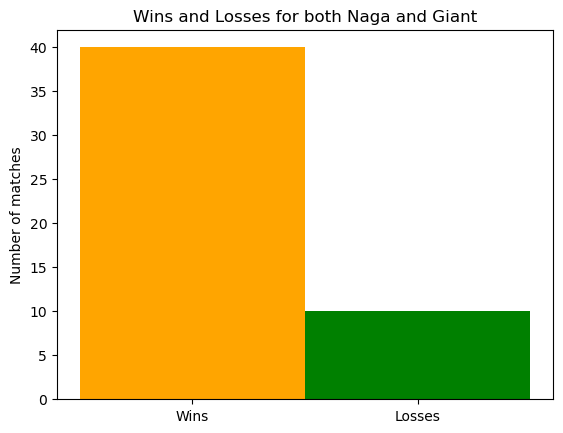

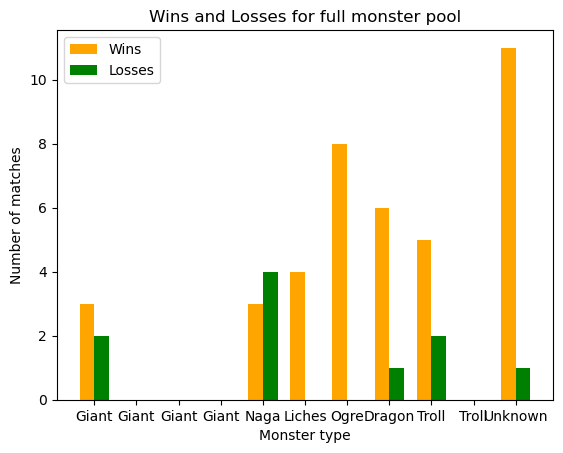

In [2]:
NUM_EP = 50

ENV = gym.make("MiniHack-HideNSeek-Mapped-v0",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
monsterWins1Full, monsterLosses1Full, wins1Full = evaluate(num_ep = NUM_EP, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

losses1Full = NUM_EP - wins1Full

plot([wins1Full, losses1Full], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses for both Naga and Giant")

plot(monsterWins1Full, "3", 0.35, kb_labels, "Number of matches", "Wins and Losses for full monster pool", monsterLosses1Full, "Monster type")

In [ ]:

ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_N.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, wins1Naga = evaluate(num_ep = NUM_EP, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH


In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_H.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, wins1Giant = evaluate(num_ep = NUM_EP, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH


### Dealing with monsters
Though not catastrophic, the strategy of ignoring the monster isn't enough, especially against the **Naga**. She rocks a powerful fire ranged attack, whilst having the same speed as the agent.
Since enemies can attack us at range from basically *any* distance, performing intricated movement strategies would both put us at risk of exceeding the maximum number of steps and give the monster more attempts to hit us at range. 
When dealing with monsters, one useful thing is that ranged attacks seem to have a *lower* chance to connect if the line of fire is not exactly *perpendicular* (or *diagonal*). Thus, we made the agent less prone to walk in those cells, as well as the cells strictly adjacent to the monster. Also, the agent keeps tracks of the last enemy position, when it disappears into clouds.


In [ ]:

ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_NH.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "slow", show = True)

### Evaluation II
Again, some evaluation on the different monster pools. The Knowledge Base tweaks brought an improvement in all of the three monster pools performance.

In [ ]:
ENV = gym.make("MiniHack-HideNSeek-Mapped-v0",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
monsterWins2Full,monsterLosses2Full, wins2Full = evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)


In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_N.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, _, wins2Naga = evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)


In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_H.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
_, _, wins2Giant = evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)


# Heuristic Search 

The idea was to approach the problem in an increasing level of difficolty fashion, first working on some simpler heuristics and cost functions, up to reaching a more sofisticated level of complexity. 

We started by comparing the Euclidean Distance and the Chebyshev Distance, to better understand how to approach the problem.  After a brief analysis, we realized that the Chebyshev Distance was exactly what we needed, because it provided eight normal vectors that accurately matched the possible actions of the agent.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=("chars", "pixel", "colors"), des_file = "dat/simple_maze.des")
solve_and_plt(env, heuristic=euclidean_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

Initially, a simpler version of the problem was tackled. An A* algorithm was implemented that could find the optimal path in a map with trees.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/square_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The algorithm also works on more intricate map configurations, that are not constrained to a square shape.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/maze_trees.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(50, 270), plt_height=(500, 760))

The problem was made more complex with the introduction of clouds and a "grid bug," a relatively weak monster in Nethack. This creature, matching the player's speed, is unable to ever catch up with the agent, adding a strategic element to the scenario. 

To effectively face this issue, a dynamic A* algorithm was implemented. This solution recalculates the path based on whether the monster is visible or not. In scenarios where the monster is visible, the agent incurs no penalties traversing through clouded areas. Instead, in instances where the monster remains hidden, traversing through clouded regions carries a risk, as these areas might serve as secret hiding places for the lurking monster.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/grid_bug.des")
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The final stage of the fully observable problem involved addressing the comprehensive challenge at hand. A diverse array of monsters was integrated into the scenario. 

Initially, we relied solely on the strategy discussed up to this point, but we soon realized that it required further refinement.

In [ ]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="base", plt_width=(100, 270), plt_height=(500, 760))

The idea behind the improved strategy roots in two simple concepts:
- when the agent has the chance to see the monster in the map, it should keep itself further from it
- when the agent does not have a chance to get to know where the monster may be hiding itself, the agent must stay further from clouds as much as it might, for this very reason

In [ ]:
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

Let us give a brief discussion on the reasons behind the procedure rightfully working.

First, we will introduce the formulation of the Chebyshev Distance, i.e:
$$\text{let} \quad P = (p_1, p_2), \quad \text{and} \quad Q = (q_1, q_2)$$
$$d(P, Q) = \max(|p_1 - q_1|, |p_2 - q_2|)$$

The idea, as expressed before in more abstract terms, is to keep the agent as far as possible from the monster whenever it is visible. This can be obtained by setting the $g$ function of the cost function $f$ in such a way that it weights cells closer to the monster more than cells further from it. 

Let us first define the cost function $f$:
$$f(P, T) := g(P, D) + h(P, T),$$
$$\text{where P is the neighbour position},$$
$$\text{D is the danger position},$$
$$\text{and T is the target position}$$

Note: the definition of the function $g$ actually needs to be taken in a more flexible way since, as we will see later, it will be having parameters of different types throughout all the instances of the problem. Specifically, $D$ should be considered as a set, and $g$ musti be defined with a specific formulation.

Anyway, what we mentioned above can be obtained by a simple manipulation of the function we used for the calculation of the distance between points in the plane, i.e. by simply calculating the reciprocal of the Chebyshev Distance between the position and the monsters itself. This gives us a function which is "rotation aware": it assigns the same value to positions falling in the radius of a circle (really squares to be precise, since the Chebyshev Distance actually is the $L_{\infty}$)).

$$\text{let} \quad \text{M be the monster's position},$$
$$\text{and} \quad \psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

$$\text{and} \quad h(P, T) := d(P, T)$$

We can obtain the cost function $f$ designed as described by setting $g = \psi$.

Notice that with $g$ we are comparing our neighbouring position $P$ with the monster position $M$, while with $h$ we are computing the exact distance (thanks to the Chebyshev Distance) between the neighbouring position $P$ and the target $T$.

For precisions's sake, we implemented the above function with a slight variation. Basically, we considered two different cases from when the agent knows where the monster is: one where $P$ is a cloud, and another one where $P$ is not a cloud. As one might think, it can be advantageous to exploit clouds in order to run off the monster, but clouds have to be weighted carefully. In fact, we did not want the agent to risk running into the monster just because it is trying to get to a cloud. To achieve this goal, we chose a simple yet effective (at least empirically) approach, based on a very simple manipulation of the above function: 

$$\psi(P, M) := 
\begin{cases} 
    \frac{1}{d(P, M)}  & \text{if } d(P, M) > 0 \quad \text{and } P \notin Clouds, \\
    \left \lfloor \frac{1}{d(P, M)} \right \rfloor  & \text{if } d(P, M) > 0 \quad \text{and } P \in Clouds, \\
    maxcost & \text{if } d(P, M) = 0
\end{cases}, \quad \text{with} \quad maxcost = 10^{5}$$

The intuition behind this, is that the floor gives a very slight advantage to the cloud position in the cost function, precisely an advantage $< 1$. This can be enough given that values will not be too large due to the size of the map, hence we will not need major adjustments.

Let us make an observation about what we have seen so far: for now, our approach only targets situations where the agent knows where the monster is located. However, in scenarios where the monster's position is unknown, we need to make some more considerations. Here, the agent should be cautious about approaching clouds, as they are ideal places for monsters to hide. To tackle this issue, we developed a specific function:

$$\varphi(P, Clouds) := \sum_{C \in Clouds} \frac{1}{d(P, C)}$$

This function $\varphi$ can be interpreted as the "danger function": it gives a value to represent how "dangerous" a position really is, basing the computation on the distance between a given position and each cloud in the map. To achieve this, we again exploited the reciprocal of the Chebyshev Distance, but this time we summed the amount of "danger" that each cloud have projected to the specific cell.

As before, we can use the original formulation, $f(P, T) := g(P, D) + h(P, T)$, to express the cost function, but this time $g = \varphi$.

$$f(P, T) := \sum_{C \in Clouds} \frac{1}{d(P, C)} + h(P, Q)$$

So, we exploited the original formulation of $f$ to handle both scenarios: one where the monster is visible and another where it is not. This was achieved by simply replacing $g$ with the appropriate function for each specific case.

Another important observation is that, in the case in which the agent does not know the monster's position, $g$ does not grow linearly as $h$ does (since it is of the form $\frac{1}{n}$ for the most part), hence this brings the conclusion that $h$ will have a bigger impact on most cases (i.e. each case where $h(P, T) > g(P, M)$, or to put it into words, every time the distance from the target is larger than the reciprocal of the distance from the monster, basically in most occasions). When we consider the case of $g = \varphi$, the reasoning actually changes a bit, since we are summing over the number of clouds in the map. In any case, this should not affect the algorithm in any particular way.

To conclude the discussion, all this machinery can be interpreted as a filtering function: the first filter applies to positions that share the same value of $h$ (since that is the most weighted value), and amongst them the agent chooses the one that is less dangerous to be percolated.

A more involved analysis might be interesting to be carried on, but the choice to stop to this point is both of practical meaning and time constraints.

However, let us us return to the core issue. 
As previously mentioned, some monsters in the MiniHack HideNSeek environment are too powerful to face with an empty inventory. Therefore, we have chosen to concentrate on a smaller group, specifically focusing on two monsters: the Naga and the Giant Humanoid.

In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_NH.des", observation_keys=["chars", "pixel", "colors"])
solve_and_plt(env, heuristic=chebyshev_distance, precision="advanced", plt_width=(100, 270), plt_height=(500, 760), dynamic=True)

Let us examine the statistics concerning different the map configurations.

In these and the following charts, the label "unknown" refers to all the instances where the agent either won or lost without seeing which monster was on the map. In the first case, this probably happened because the agent appeared very close to the stairs and quickly reached them before the monster revealed itself (possibly hiding in the clouds). In the second case, the agent was likely killed by a ranged attack from a hidden monster. Another point to consider is that all the statistics are run over 500 episodes, with a maximum of 30 steps.

Initially, let us consider the map where both monsters have an equal probability of appearing.
The first histogram represents the total wins and losses: it is clear that the number of victories is significantly higher than the number of defeats, and this proves that our algorithm works in most cases.
The second histogram represents the total wins and losses for each type of monster. 

In [ ]:

win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_NH.des", evaluation_steps=500)

plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses for both Naga and Giant")

plot(monsters_win, "2", 0.35, labels, "Number of matches", "Wins and Losses for both Naga and Giant", monsters_loss, "Monster type")

Let us have a look at the performance over Naga and the Giant alone.

Generally, the win rate is higher in maps featuring only the giant compared to those with only the Naga. This is because, in maps with only the Naga, the agent tends to die more frequently without the monster being visible. This is due to the lethal long-range attack of the Naga, which hits the agent before the monster becomes visible. Additionally, the agent has no defenses against this type of attack, both because it lacks an inventory and because not seeing the monster fails to trigger the logic of the evasion mechanism in the algorithm.

In [ ]:
# NAGA
win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_N.des", evaluation_steps=500)

plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses for Naga")

plot(monsters_win, "2", 0.45, labels, "Number of matches", "Wins and Losses for Naga", monsters_loss, "Monster type")

In [ ]:
# GIANT
win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_path_finding, des_file="dat/fully_observable_H.des", evaluation_steps=500)


plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses for Giant")

plot(monsters_win, "2", 0.45, labels, "Number of matches", "Wins and Losses for Giant", monsters_loss, "Monster type")

Now, let us have a look at how the algorithm performs on the entire pool of monsters from HideNSeek. 

The algorithm remains effective even in this case, despite the increased difficulty that facing these monsters without an inventory can pose. In general, win and loss percentages are subject to various influencing factors, including the agent's proximity to the stairs (closer proximity increases the likelihood of reaching them without being killed) and the characteristics of the monster, coupled with its position relative to the agent (for example, favorable outcomes occur when a monster with a potent long-range attack is nearby). These variables are inherently unpredictable. 

Furthermore, in this specific context, the frequency of a monster's appearance in runs can impact the win rate, a variable beyond our control, as each monster has an equal probability of appearing on the map in every run.
Therefore, to comprehensively assess the effectiveness of our algorithm for each type of monster in HideNSeek, a rigorous evaluation would involve running the algorithm on individual maps for each monster type. However, despite this, we can assert the algorithm's general effectiveness based on its performance across 500 episodes.

In [ ]:
win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-HideNSeek-Mapped-v0", dynamic_path_finding, evaluation_steps=500)


plot([win, loss], "1", 1, ["Wins", "Losses"], "Number of matches", "Wins and Losses for all Monsters")

plot(monsters_win, "2", 0.35, labels, "Number of matches", "Wins and Losses for all Monsters", monsters_loss, "Monster type")


Another noteworthy statistic to analyze is the evaluation of the win rate and speed across the different versions of the implemented algorithm.

We consider:
- the static version (indicated with the label with "A*"), where the path is calculated only at the beginning of the episode and remains unchanged;
- the initial implementation of the dynamic version (indicated with the label "dynamic 1"), where the cost associated with clouds is based solely on the presence or absence of the monster;
- the latest dynamic version (indicated with the label "dynamic 2"), where the weight of the squares is determined through the calculation explained earlier in detail.

The comparison is carried out on three different maps: one with only Naga, one with only Giant, and one with all the monsters from Hide and Seek.

In [ ]:
#Solo NAGA
env = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_N.des", observation_keys=["chars", "pixel", "colors"])

#STATIC
start_time = time.time()
win1 = simple_evaluation(env, precision="base", dynamic=False, steps = 500)
end_time = time.time()
astar = end_time - start_time

#DYNAMIC1
start_time = time.time()
win2 = simple_evaluation(env, precision="base", dynamic=True, steps = 500)
end_time = time.time()
dynamic1 = end_time - start_time

#DYNAMIC2
start_time = time.time()
win3N = simple_evaluation(env, precision="advanced", dynamic=True, steps = 500)
end_time = time.time()
dynamic2 = end_time - start_time

plot([win1, win2, win3N], "1", 0.70, ["A*", "Dynamic 1", "Dynamic 2"], "Percentage", "Comparison of Win Rates Against Naga", percentage=500)

plot([astar, dynamic1, dynamic2], "1", 0.70, ["A*", "Dynamic 1", "Dynamic 2"], "Seconds", "Comparison of Execution Time for 500 Episodes")

In [ ]:
#Solo GIGANTE
env = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_H.des", observation_keys=["chars", "pixel", "colors"])

#STATIC
start_time = time.time()
win1 = simple_evaluation(env, precision="base", dynamic=False, steps = 500)
end_time = time.time()
astar = end_time - start_time

#DYNAMIC1
start_time = time.time()
win2 = simple_evaluation(env, precision="base", dynamic=True, steps = 500)
end_time = time.time()
dynamic1 = end_time - start_time

#DYNAMIC2
start_time = time.time()
win3G = simple_evaluation(env, precision="advanced", dynamic=True, steps = 500)
end_time = time.time()
dynamic2 = end_time - start_time


plot([win1, win2, win3G], "1", 0.70, ["A*", "Dynamic 1", "Dynamic 2"], "Number of matches", "Comparison of Number of Games Won Against Giant", percentage=500)

plot([astar, dynamic1, dynamic2], "1", 0.70, ["A*", "Dynamic 1", "Dynamic 2"], "Seconds", "Comparison of Execution Time for 500 Episodes")

In [ ]:
#Monster pool
env = gym.make("MiniHack-HideNSeek-Mapped-v0", observation_keys=["chars", "pixel", "colors"])

#STATIC
start_time = time.time()
win1 = simple_evaluation(env, precision="base", dynamic=False, steps = 500)
end_time = time.time()
astar = end_time - start_time

#DYNAMIC1
start_time = time.time()
win2 = simple_evaluation(env, precision="base", dynamic=True, steps = 500)
end_time = time.time()
dynamic1 = end_time - start_time

#DYNAMIC2
start_time = time.time()
win3M = simple_evaluation(env, precision="advanced", dynamic=True, steps = 500)
end_time = time.time()
dynamic2 = end_time - start_time


plot([win1, win2, win3M], "1", 0.70, ["A*", "Dynamic 1", "Dynamic 2"], "Number of matches", "Comparison of the Number of Games Won Against the Entire Monster Pool", percentage=500)

plot([astar, dynamic1, dynamic2], "1", 0.70, ["A*", "Dynamic 1", "Dynamic 2"], "Seconds", "Comparison of Execution Time for 500 Episodes")

## Test on blend features 


The next step involved combining the two strategies, the knowledge base, and the dynamic pathfinding algorithm, to analyze the obtained results and assess whether this could be a viable strategy.

In the following tests, the maximum number of steps for each episode is set to 100. Once that step limit is reached, the episode will conclude with the **noAction** state.

In [ ]:
def solve_and_plt(env: gym.Env, heuristic: callable, precision: str, plt_width: Tuple[int, int], plt_height: Tuple[int, int], dynamic: bool = False, suppress = False):
    state = env.reset()
    game_map = state["chars"]
    color_map = state["colors"]
    pixel_map = state["pixel"]

    start = get_player_location(game_map)
    target = get_target_location(game_map)

    if dynamic:
        dpt_test(game_map, color_map, start, target, env, heuristic, precision=precision, graphics=True, pixel_map=pixel_map, suppress=suppress)
    else:
        path = a_star(game_map, color_map, start, target, heuristic, precision=precision)
        actions = actions_from_path(start, path[1:])
        render_actions(actions, env, pixel_map, plt_width, plt_height)

### Test on Naga Blend

In both the case of the Naga and the Giant, we employed the following technique: initially, the agent relies solely on dynamic pathfinding algorithms. As soon as the agent spots the monster, the Knowledge Base comes into play.

This technique is effective for the Naga because 

#TO DO EXPLAIN BETTER BASING THE EXPLANATION ON THE PREVIOUS STATS RESULTS (KB MORE EFFICIENT FOR NAGA) 

In [ ]:
#NAGA
win, loss,noAction, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dpt_test, des_file="dat/fully_observable_N.des", evaluation_steps=500, graphics=False)

data = [win, loss]
x_label = ["Wins", "Losses"]
if noAction:
    data.append(noAction)
    x_label.append("No Action")

plot(data, "1", 1, x_label, "Number of matches", "Wins and Losses for Naga")

plot(monsters_win, "2", 0.45, labels, "Number of matches", "Wins and Losses for Naga", monsters_loss, "Monster type")


### Test on Giant blend


Initially, the same technique used for the Naga was also applied to address the Giant. 

In [ ]:
win, loss,noAction, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dpt_test, des_file="dat/fully_observable_H.des", evaluation_steps=500, graphics=False)

data = [win, loss]
x_label = ["Wins", "Losses"]
if noAction:
    data.append(noAction)
    x_label.append("No Action")

plot(data, "1", 1, x_label, "Number of matches", "Wins and Losses for Giant")

plot(monsters_win, "2", 0.45, labels, "Number of matches", "Wins and Losses for Giant", monsters_loss, "Monster type")


However, a different approach was later implemented. In this case, the agent initially relies on dynamic pathfinding. When it detects the presence of the monster, it switches to the Knowledge Base. However, when the agent moves a sufficient distance away from the monster, it reverts back to employing the dynamic pathfinding algorithm.

#TO DO EXPLAIN BETTER BASING THE EXPLANATION ON THE PREVIOUS STATS RESULTS (A* MORE EFFICIENT FOR GIANT ????) 

In [ ]:
win, loss,noAction, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dpt_testv2, des_file="dat/fully_observable_H.des", evaluation_steps=500, graphics=False)

data = [win, loss]
x_label = ["Wins", "Losses"]
if noAction:
    data.append(noAction)
    x_label.append("No Action")

plot(data, "1", 1, x_label, "Number of matches", "Wins and Losses for all Monsters")

plot(monsters_win, "2", 0.45, labels, "Number of matches", "Wins and Losses for all Monsters", monsters_loss, "Monster type")


## Comparison Between Knowledge Base, Heuristic Search and Blended Strategy

##TO DO (time and win rate)

# The partially observable environment

In the partially observable environment, an agent's behavior must be adapted to handle the uncertainty and dynamics of the map. The main challenge in this scenario is the changing map configuration in each episode, making it impossible for the agent to rely on pre-existing knowledge or a predetermined path. Additionally, exploration becomes crucial since the stairs, which are the final objective, are not immediately visible.

If the stairs are visible, the agent will naturally choose them as the target. Otherwise, the idea is to choose a random position on the frontier as a temporary target. The frontier in this context refers to the limits of the area currently visible to the agent. By moving towards this position, the agent can explore new areas of the map, thereby increasing the likelihood of finding the stairs. Additionally, the algorithm keeps track of positions previously chosen as targets to avoid selecting them again.


In [ ]:
env = gym.make("MiniHack-Navigation-Custom-v0", observation_keys=["chars", "pixel", "colors"], des_file="dat/partially_observable_NH.des")

state = env.reset()
game_map = state["chars"]
color_map = state["colors"]
pixel_map = state["pixel"]

start = get_player_location(game_map)

dynamic_pathfinding_po(game_map, color_map, start, env, chebyshev_distance,"advanced", True, True, pixel_map)

win, loss, _, monsters_win, monsters_loss = evaluate_performance("MiniHack-Navigation-Custom-v0", dynamic_pathfinding_po, des_file="dat/partially_observable_NH.des", evaluation_steps=300, po = True)

